# README

This notebook is intended to serve as a test site for code related to experimenting with the ECCO bird data and simulated drone data. 

The notebook is organized by sections as follows:
<ol type="I">
    <li><b>General:</b> code meant to be used across all of the sections (e.g., imports, common constants, helper functions, etc.).
    <li><b>Preprocessing:</b> anything having to do with preprocessing the datasets (e.g., dropping columns, reformatting fields, etc.).
    <li><b>Principal Component Analysis:</b> dedicated to analyzing data with PCA.
    <li><b>Comparing Classifiers:</b>: testing different classifiers and comparing for accuracy. 
</ol>
These sections are meant to be (more or less) independent of each other. For example, <b>Principal Component Analysis</b> doesn't need to be run before <b>Comparing Classifiers</b>. You can choose which preprocessing cells to run depending on your needs.


# I. General

### Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid
import numpy as np

from datetime import datetime
from sklearn import metrics, svm, tree
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Constants

In [3]:
# ecco fields deemed not important by aaron
NI_ECCO = ['User Edit Time', 'Type', 'Associated UUID', 'Note', 'Combat ID', 
           'Creator', 'Editor', 'AZ', 'Range', '2525', 'Closest Distance', 
           'Course', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 'AIS Ship Type', 
           'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks']

# fields that only have one or two unique values:
# Source Name:  ['RPS82-90deg' 'ctcve']
# Source Class: ['RADAR']
# Source LID:   [21. 49.]
# Closest Time: [0.]
REPEAT_ECCO = ['Source Name', 'Source Class', 'Source LID', 'Closest Time']

# all other ecco fields (aside from position, velocity, heading)
OTHER_ECCO = ['Name', 'Create Time', 'Object ID', 'Origin Position (lat)',
              'Origin Position (lon)', 'Origin Position (alt MSL)', 'Radar Cross Section',
              'Source ID', 'Deleted', 'Deleted Time']

# the ecco fields related to time
TIME_COLS = ['Create Time', 'Update Time', 'Deleted Time']

# mapping between ecco and simulated
ECCO_SIMU_MAP = {
    'Update Time': 'UpdateTime',
    'Range To Contact': 'Range',
    'Bearing To Contact': 'AZ',
    'EL': 'EL',
    'Position (lat)': 'Position_lat_',
    'Position (lon)': 'Position_lon_',
    'Position (alt MSL)': 'Position_altMSL_',
    'Speed': 'Speed',
    'Radial Velocity': 'RadialVelocity'
}


### Helper Functions

In [4]:
# prints a summary of each dataframe passed in
# - dfs: a list of pandas dataframes
def printInfo(dfs):
    for df in dfs:
        print(df.info())
        print('\n======================================================\n')

# reformats the time columns in ecco
# time_str: a time value from ecco (formatted as a string)
def formatTime(time_str):
    # convert the time (a string) to a datetime
    time_obj = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    return time_obj

# compares a set of predictions to true labels and prints accuracy
def printAccuracy(y_pred, y_true):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    print(f'accuracy = {100 * accuracy}\n')

def fitDistribution(sampleList, targetList):
    mu1 = np.mean(targetList)
    mu2 = np.mean(sampleList)
    var1 = np.var(targetList)
    var2 = np.var(sampleList)

    scale = np.sqrt(var2/var1)
    shift = mu2 - scale*mu1

    scaledList = targetList*scale + shift
    return scaledList

### Load ECCO and Simulated Datasets

In [101]:
# load ecco dataset
df_ecco = pd.read_csv('Data/ecco.csv')
df_ecco.name = 'ecco.csv'

# load simulated dataset
simulatedTracks = []
simulatedData = ['Data/simulatedDroneData.csv', 'Data/simulatedDroneData2.csv', 'Data/simulatedDroneData3.csv', 'Data/simulatedDroneData4.csv']

for data in simulatedData:
    simulatedTracks.append(pd.read_csv(data))
    
# display a summary of the fields for each dataset
printInfo([df_ecco, simulatedTracks[0]])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17587 entries, 0 to 17586
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   UUID                       9553 non-null   object 
 1   Name                       9553 non-null   object 
 2   Create Time                9553 non-null   object 
 3   Update Time                9553 non-null   object 
 4   User Edit Time             62 non-null     object 
 5   Type                       9553 non-null   object 
 6   Associated UUID            9553 non-null   object 
 7   Note                       0 non-null      float64
 8   Source Name                9553 non-null   object 
 9   Source Class               9553 non-null   object 
 10  Source LID                 9553 non-null   float64
 11  Combat ID                  9553 non-null   object 
 12  Object ID                  9553 non-null   object 
 13  Range To Contact           9553 non-null   flo

c:\Users\Conor\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,11,12,26,34,35,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# II. Preprocessing

### Drop Rows and Columns from ECCO

In [102]:
# drop non-important features from ecco dataset
DROP_ECCO = NI_ECCO + REPEAT_ECCO
print(f'dropping the following fields:\n{DROP_ECCO}...\n')
df_ecco = df_ecco.drop(columns=DROP_ECCO)

# display a summary of the fields for each dataset
printInfo([df_ecco])

# drop all rows with nan
print(f'rows before dropping nan: {len(df_ecco)}')
df_ecco = df_ecco.dropna()
print(f'rows after dropping nan: {len(df_ecco)}')


dropping the following fields:
['User Edit Time', 'Type', 'Associated UUID', 'Note', 'Combat ID', 'Creator', 'Editor', 'AZ', 'Range', '2525', 'Closest Distance', 'Course', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 'AIS Ship Type', 'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks', 'Source Name', 'Source Class', 'Source LID', 'Closest Time']...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17587 entries, 0 to 17586
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   UUID                       9553 non-null   object 
 1   Name                       9553 non-null   object 
 2   Create Time                9553 non-null   object 
 3   Update Time                9553 non-null   object 
 4   Object ID                  9553 non-null   object 
 5   Range To Contact           9553 non-null   float64
 6   Bearing To Contact         9553 non-null   float64
 7   EL                         9551 n

### Reformat Time Columns in ECCO

In [103]:
# display the first few values of each time column before formatting
print('Time columns before reformatting:')
for tc in TIME_COLS:
    print(f'{tc}: {type(df_ecco[tc][0])}')
print(df_ecco[TIME_COLS].head())

# reformat each of the time columns (one-by-one)
for tc in TIME_COLS:
    df_ecco[tc] = df_ecco[tc].apply(formatTime)

# display the first few values of each time column after formatting
print('\n======================================================\n')
print('Time columns after reformatting:')
for tc in TIME_COLS:
    print(f'{tc}: {type(df_ecco[tc][0])}')
print(df_ecco[TIME_COLS].head())


Time columns before reformatting:
Create Time: <class 'str'>
Update Time: <class 'str'>
Deleted Time: <class 'str'>
                   Create Time                  Update Time  \
0  2022-06-16T17:52:01.898832Z  2022-06-16T17:54:45.692026Z   
1  2022-06-16T17:53:00.654140Z  2022-06-16T17:54:45.692520Z   
2  2022-06-16T17:52:01.898832Z  2022-06-16T17:54:45.725468Z   
3  2022-06-16T17:52:01.898832Z  2022-06-16T17:54:45.829479Z   
4  2022-06-16T17:52:06.462136Z  2022-06-16T17:54:45.840658Z   

                  Deleted Time  
0  2022-06-16T18:00:30.308269Z  
1  2022-06-16T17:58:09.980982Z  
2  2022-06-16T18:00:30.308269Z  
3  2022-06-16T18:00:30.308269Z  
4  2022-06-16T17:58:16.230071Z  


Time columns after reformatting:
Create Time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Update Time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Deleted Time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
                 Create Time                Update Time  \
0 2022-06-16 17:52:0

### Match ECCO Fields to Simulated Fields

In [104]:
# create UUIDs for the simulated data
for data in simulatedTracks:
    track_IDs = [None] * len(data)

    for i in range(len(data)):
        if i % 10 == 0:
            id = str(uuid.uuid1())
        track_IDs[i] = id

    data['UUID'] = track_IDs


# drop all remaining columns from ecco that aren't in simu
df_ecco = df_ecco.drop(columns=OTHER_ECCO)

# rename all of the ecco columns to match simu
df_ecco = df_ecco.rename(columns=ECCO_SIMU_MAP, errors='raise')

# reorder df_ecco columns to match up with df_simu
df_ecco = df_ecco.reindex(columns=simulatedTracks[0].columns)

# compare the column names of ecco and simu
same = df_ecco.columns.to_list() == simulatedTracks[0].columns.to_list()
print(f'are the ecco and simu column names equal? {same}')

are the ecco and simu column names equal? True


### Separate ECCO tracks by UUID

In [105]:
eccoTracks = list(df_ecco.groupby('UUID'))

### Noise Generation

In [106]:
general_scaling = 32

for track in simulatedTracks:
    #Speed noise
    track['Speed'] += np.random.normal(scale=track['Speed'].std()/general_scaling, size=(len(track)))
    track['RadialVelocity'] += np.random.normal(scale=track['RadialVelocity'].std()/general_scaling, size=(len(track)))

    #Angle Noise
    track['AZ'] += np.random.normal(scale=track['AZ'].std()/general_scaling, size=(len(track)))
    track['EL'] += np.random.normal(scale=track['EL'].std()/general_scaling, size=(len(track)))

    #Position Noise
    track['Position_lat_'] += np.random.normal(scale=track['Position_lat_'].std()/general_scaling, size=(len(track)))
    track['Position_lon_'] += np.random.normal(scale=track['Position_lon_'].std()/general_scaling, size=(len(track)))
    track['Position_altMSL_'] += np.random.normal(scale=track['Position_altMSL_'].std()/general_scaling, size=(len(track)))
    track['Range'] += np.random.normal(scale=track['Range'].std()/general_scaling, size=(len(track)))

### Fit data to ECCO distribution

In [107]:
cols_to_fit = ['AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_', 'Position_altMSL_', 'Speed', 'RadialVelocity']

for i, track in enumerate(simulatedTracks):
    for feature in cols_to_fit:
        track[feature] = fitDistribution(eccoTracks[i][1][feature][:len(track[feature])], track[feature])

### Combine data

In [108]:
df_simu = pd.concat([simulatedTracks[0], simulatedTracks[1], simulatedTracks[2], simulatedTracks[3]], ignore_index=True)
df_simu = df_simu.sort_values(by='UpdateTime', ascending=True)
df_simu.name = 'simulatedDroneData.csv'

### Save new CSV

In [109]:
df_simu.to_csv('Data/scaledSimulationData.csv', index=False)

### Plot Data

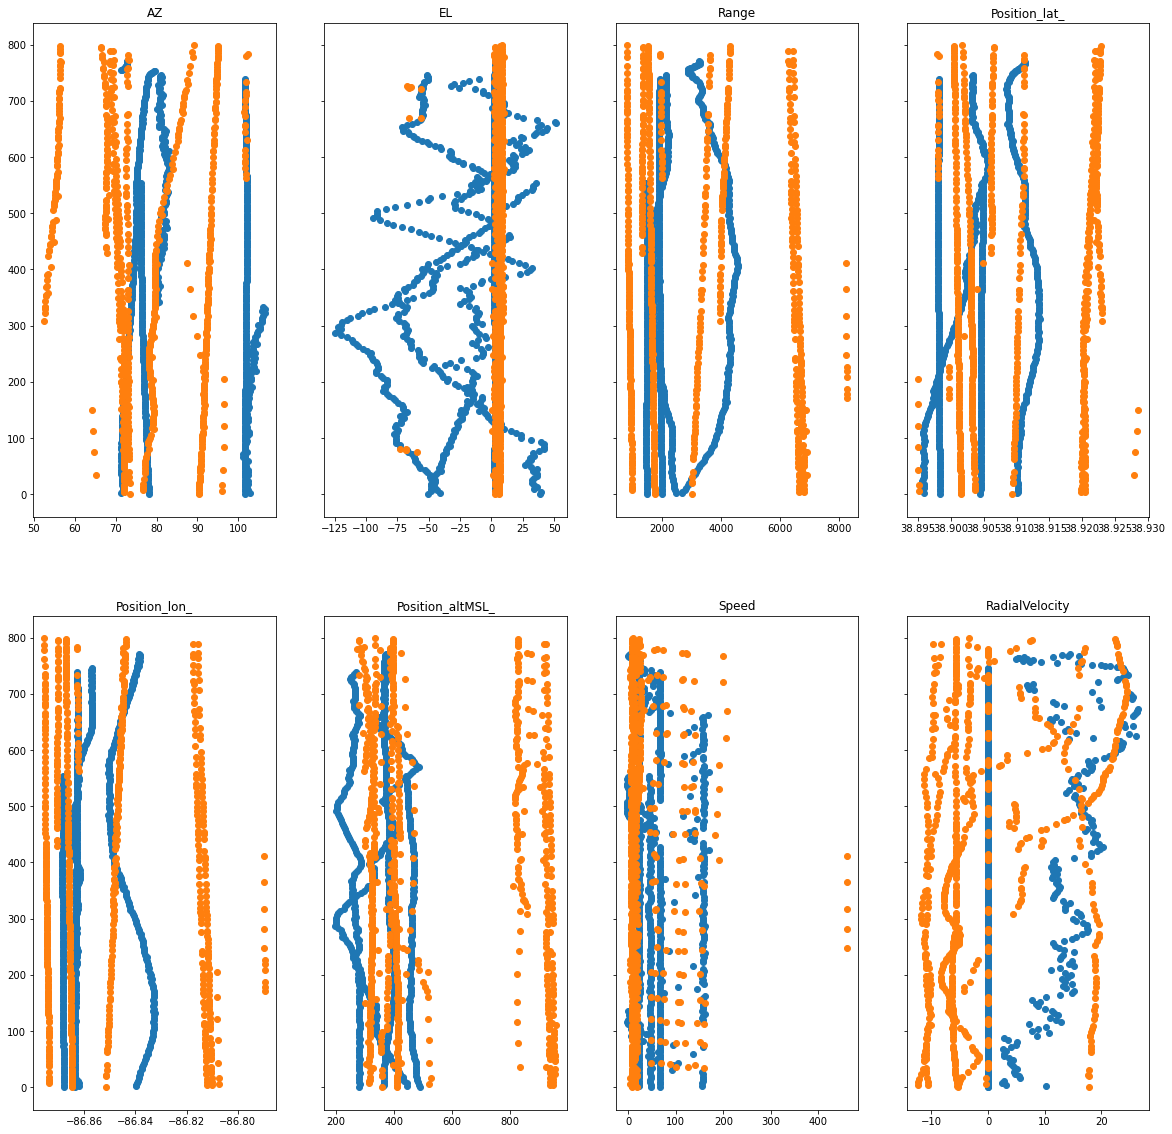

In [111]:
graph = ['AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity']

df_ecco_short = df_ecco[:800]

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,20), sharey=True)

for i, ax in enumerate(axes.flatten()):
    plot = ax.scatter(df_simu[graph[i]], np.arange(len(df_simu['RadialVelocity'])))
    plot = ax.scatter(df_ecco_short[graph[i]], np.arange(len(df_ecco_short['RadialVelocity'])))
    ax.set_title(graph[i])

### ECCO data analysis

In [112]:
M = df_ecco.drop(columns=['UpdateTime', 'UUID'])
M = M[:100]
M = M.values

reduced_data = PCA(n_components=2).fit_transform(M)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=2)
kmeans.fit(reduced_data)

KMeans(n_clusters=2, n_init=2)

# III. Principal Component Analysis

In [113]:
# add labels to ecco and simu
df_ecco['Label'] = 0
df_simu['Label'] = 1

# combine ecco and simu into one dataset
X = pd.concat([df_ecco, df_simu])

# create the labels using the label column of X
y = X['Label']

# drop the label column from X
X = X.drop(columns='Label')

# for now, also drop times
X = X.drop(columns=['UpdateTime'])


In [114]:
# we want to scale all features except for UUID
uuid_idx = X.columns.get_loc('UUID')
X_cols = X.columns.delete(uuid_idx)

# first scale simu based on eco
simuScaler = StandardScaler()
simuScaler.fit(X[X_cols])

# the scaled columns should have mean 0 and std 1
scaler = StandardScaler()
scaler.fit(X[X_cols])

scaled_X = pd.DataFrame(scaler.transform(X[X_cols]))

### Perform PCA 

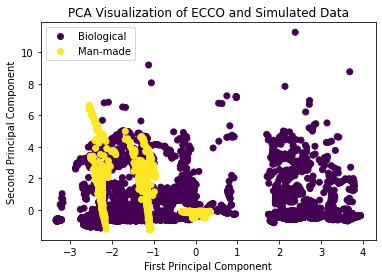

<AxesSubplot:>

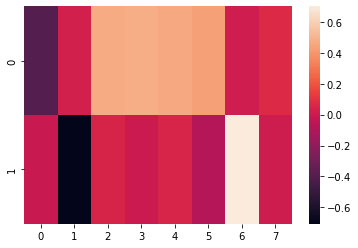

In [115]:
# perform PCA on the scaled data
pca = PCA(n_components=2)
pca.fit(scaled_X)
X_pca = pca.transform(scaled_X)

# plot the first PC vs the second PC
plot = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization of ECCO and Simulated Data')
plt.legend(handles=plot.legend_elements()[0], labels=['Biological', 'Man-made'])
plt.show()

components = pd.DataFrame(pca.components_, columns=scaled_X.columns)
sns.heatmap(components)


# IV. Comparing Classifiers

### Classification: Attempt 1
This first round of classifiers is trained on the raw track data, without extracting any derivative data. Therefore, it makes predictions on a purely sample-by-sample basis. This is intended to give us a feel for how these classifier perform in comparison each other.

Random forest and SVM were chosen as these are two main traditional ML approaches we've come accross in our research that have been used for this problem. 

In [116]:

# split the data into distinct training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

# define the classifiers
rf = RandomForestClassifier()
sv = svm.SVC()

# fit random forest and svm on training data, isolation forest on ecco data
rf.fit(X_train, y_train)
sv.fit(X_train, y_train)

# use the trained models to generate predictions
rf_pred = rf.predict(X_test)
sv_pred = rf.predict(X_test)

In [117]:
# report the accuracy of the models
print('random forest:')
printAccuracy(rf_pred, y_test)

print('svm:')
printAccuracy(sv_pred, y_test)

random forest:
accuracy = 100.0

svm:
accuracy = 100.0



number of trees in rf: 100


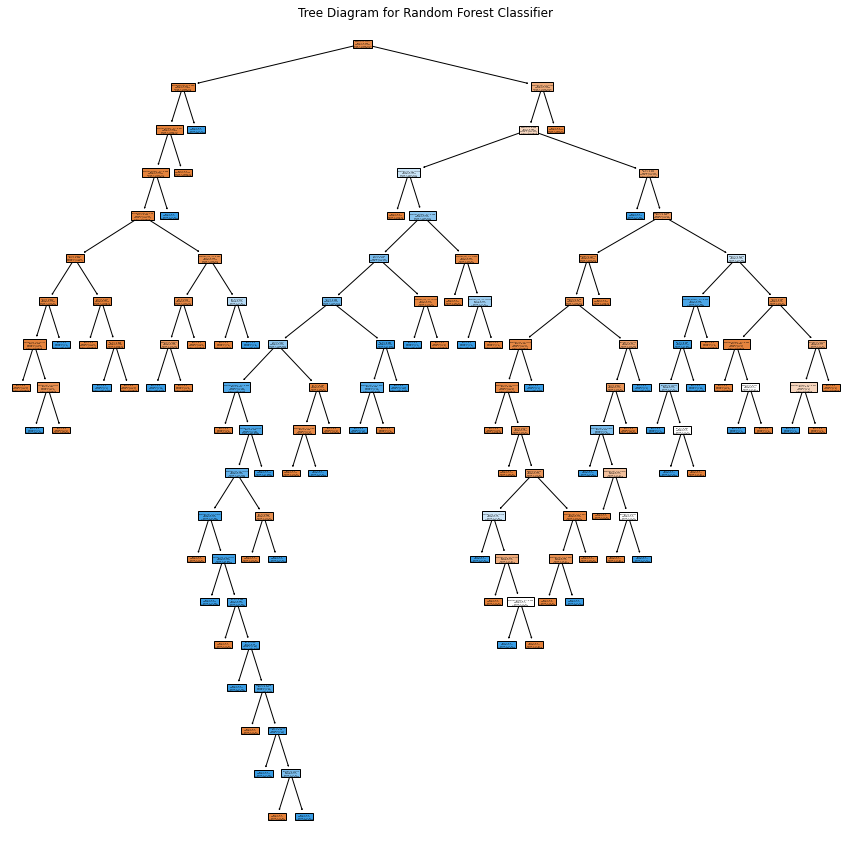

In [118]:
# visualize the first three random forst trees
print(f'number of trees in rf: {len(rf.estimators_)}')
plt.figure(figsize=(15, 15))

tree.plot_tree(rf.estimators_[0],
            feature_names = X.columns, 
            class_names=['Biological', 'Man-made'],
            filled = True)
plt.title('Tree Diagram for Random Forest Classifier')
plt.show()


### Classification: Attempt 2
Here we train the classifiers on information derived from the raw data, but not the raw data itself. The derived information is as follows:
<ul>
    <li><b>Average Speed:</b> the average speed of the track.
    <li><b>Standard Deviation of Speed:</b> the standard deviation of the speeds of the track.
    <li><b>Standard Deviation of Heading:</b> the standard deviation of the headings of the track.
    <li><b>Maneuverability Factor:</b> the average speed devided by standard deviation of heading.
    <li><b>Oscillation Factor:</b> 
</ul>

In [20]:
# 0262ede9-5be0-4368-8a1b-94dcc447c9c8
# f7b15e2c-81af-11ee-a19d-c6239e44ea3d

X_grouped = X.groupby('UUID')

# sample_group = X_grouped.get_group('f7b15e2c-81af-11ee-a19d-c6239e44ea3d')
# print(sample_group)

avg_speed = X_grouped['Speed'].mean()
print(f'average speed:\n{avg_speed.describe()}\n')

std_speed = X_grouped['Speed'].std()
print(f'standard deviation of speed:\n{std_speed.describe()}\n')


average speed:
count    162.000000
mean      44.133455
std       60.675237
min      -85.563937
25%       11.671314
50%       45.207096
75%       49.006657
max      460.415039
Name: Speed, dtype: float64

standard deviation of speed:
count    161.000000
mean      19.257673
std       29.318205
min        0.000000
25%        2.265345
50%        5.717243
75%       28.593084
max      256.555594
Name: Speed, dtype: float64



In [21]:
# Split Dataframe into a dictionary of tracks

tracks = {}

for i, ID in enumerate(df_ecco['UUID']):
  if ID in tracks:
    tracks[ID].append(df_ecco.loc[i][1:])
  else:
    tracks[ID] = [df_ecco.loc[i][1:]]

KeyError: 3782